In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 100
problem_spec['translation'] = "b"
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

# problem_spec['sc_theta'] = 2
# problem_spec['sc_theta'] = 1
# problem_spec['sc_theta'] = 0.7
problem_spec['sc_theta'] = 0.5
# problem_spec['sc_theta'] = 0.3

problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 100, 'translation': 'b'}


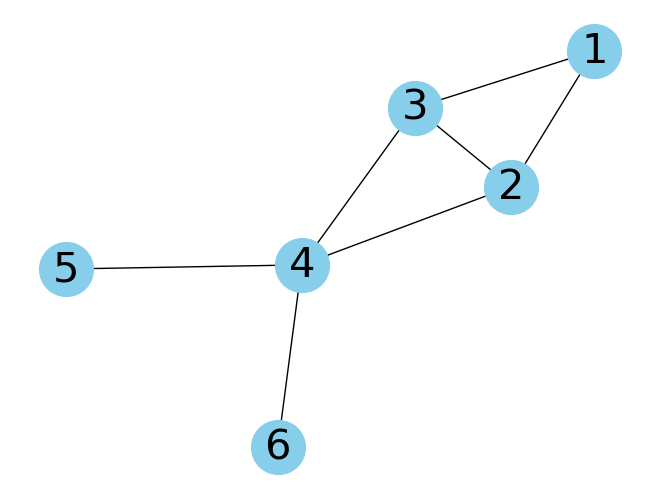

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=173364.7465675602, np.linalg.norm(x_opt_star)=948.8196891687014


In [5]:
b = problem_data['b']
c = problem_data['c']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
theta = problem_spec['sc_theta']
prox_operators = []
fi_operators = []

for jj in range(n_node):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    cj = c[jj*vector_size : (jj+1)*vector_size]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, cj=cj:  prox_fj_geom_mean_sc(z, rho, bj, cj, theta=theta)]
        fi_operators += [lambda x_kj, bj=bj, cj=cj: np.linalg.norm((x_kj - bj), ord=2) + theta*np.linalg.norm(x_kj - cj, ord=2)**2]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, cj, theta=theta)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, cj, vector_size, theta=theta)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-3

## Find best parameter for DADMM

In [6]:
find_best = True

start, end, space = 0.1, 4, 0.05

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 2)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        new_val = sum(admm_f_reldiff[50:350]) / 300
        # new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 2),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 2)

print("best_R :", best_R)

new best_R : 0.1 , new best_value : 0.024209324797232985
new best_R : 0.15 , new best_value : 0.007973637815391146
new best_R : 0.2 , new best_value : 0.0029668737551810462
new best_R : 0.25 , new best_value : 0.0011830762669745025
new best_R : 0.3 , new best_value : 0.0004949212920522846
new best_R : 0.35 , new best_value : 0.000215727334638959
new best_R : 0.4 , new best_value : 9.83161002630272e-05
new best_R : 0.45 , new best_value : 4.743420362154653e-05
new best_R : 0.5 , new best_value : 2.4670143983354776e-05
new best_R : 0.55 , new best_value : 1.4044512187187424e-05
new best_R : 0.6 , new best_value : 8.764999007931532e-06
new best_R : 0.65 , new best_value : 5.90074593845189e-06
new best_R : 0.7 , new best_value : 4.172885413690207e-06
new best_R : 0.75 , new best_value : 3.017313597596501e-06
new best_R : 0.8 , new best_value : 2.1811115017681906e-06
new best_R : 0.85 , new best_value : 1.5471970134546035e-06
new best_R : 0.9 , new best_value : 1.0578782790545408e-06
new be

In [7]:
# R = best_R
R = 0.6
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.0524118858267237, err_opt_reldiff[-1]=0.9401694234925271
ii=200, f_reldiff[-1]=4.11822698844746e-09, err_opt_reldiff[-1]=7.075588175057602e-05
ii=400, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.074222680261878e-05
ii=600, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.074222680269417e-05
ii=800, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.074222680261236e-05
ii=999, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.074222680266575e-05


## Find best parameter of P-EXTRA

In [8]:
# apply P-EXTRA 
find_best = True

start, end, space = 0.05, 2, 0.05

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, 
                                                                                                    network_data, x_opt_star, f_star, 
                                                                                                    printing=False, freq=200)
        new_val = sum(pg_f_reldiff[50:350]) / 300
        # new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :", best_rho)

new best_rho : 0.05 new best_value : 0.011636190117803131
new best_rho : 0.1 new best_value : 0.0011724852820519031
new best_rho : 0.15 new best_value : 0.00024495038808436544
new best_rho : 0.2 new best_value : 0.00014925151671356897
new best_rho : 0.25 new best_value : 0.00010951305414663092
new best_rho : 0.3 new best_value : 8.851637102649839e-05
new best_rho : 0.35 new best_value : 8.809588202362398e-05
best_rho : 0.35


In [9]:
# apply P-EXTRA 
problem_data['rho'] = best_rho
# problem_data['rho'] = 1.3
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, 
                                                                                            network_data, x_opt_star, f_star, 
                                                                                            printing=True, freq=200)

ii=0, f_reldiff[-1]=0.5291986499705408, err_opt_reldiff[-1]=0.6998896953448035
ii=200, f_reldiff[-1]=7.120087555847533e-07, err_opt_reldiff[-1]=4.7001791544059314e-05
ii=400, f_reldiff[-1]=4.384372014940654e-09, err_opt_reldiff[-1]=4.402016318154236e-05
ii=600, f_reldiff[-1]=4.347890482625496e-09, err_opt_reldiff[-1]=4.402016123994443e-05
ii=800, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=4.402016122516434e-05
ii=999, f_reldiff[-1]=4.347891993512105e-09, err_opt_reldiff[-1]=4.402016121006041e-05


## DADMM-C

In [10]:
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":1.842939271898937}
# params={"R":2, "Inductance":4, "Capacitance":4, "h":2.764408907848405}
# params={"R":1, "Inductance":6, "Capacitance":8, "h":5.13906193644284}
# params={"R":2, "Inductance":3, "Capacitance":0.5, "h":0.71692315906863}
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.321989931}
# params={"R":2, "Inductance":1, "Capacitance":1, "h":0.665836807162538}
# params={"R":1.5, "Inductance":4.5, "Capacitance":6, "h":3.50141019655701}
# params={"R":1, "Inductance":8, "Capacitance":8, "h":5.5409883749567}
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.515416990114254}
# params={"R":0.5, "Inductance":4, "Capacitance":16, "h":2.764408907848405}

### not verified parameters
# params={"R":3, "Inductance":3, "Capacitance":8/3, "h":2.4} # Work well for theta=0.3
params={"R":2, "Inductance":3, "Capacitance":4, "h":3} # Work great for theta=0.5
# params={"R":2, "Inductance":3.1, "Capacitance":47, "h":3} 
# params={"R":2, "Inductance":3.3, "Capacitance":17, "h":3}  # Dont work well for theta=0.5
# params={"R":2, "Inductance":3, "Capacitance":3, "h":3} # Work well for theta=0.5
# params={"R":2, "Inductance":3, "Capacitance":4, "h":2.1785158094003885} # from solver
# params={"R":0.85, "Inductance":2, "Capacitance":14, "h":4.8} # not bad for theta=1, good for theta=2
# params={"R":0.8, "Inductance":2, "Capacitance":12, "h":4.5} # good for theta=1
# params={"R":1.3, "Inductance":2, "Capacitance":8, "h":3.5}
# params={"R":1.2, "Inductance":2, "Capacitance":14, "h":4.7} # works no bad for theta=2

dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.4940229278932225, err_opt_reldiff[-1]=0.9293979985849904
ii=200, f_reldiff[-1]=4.347891993512105e-09, err_opt_reldiff[-1]=7.074222680097322e-05
ii=400, f_reldiff[-1]=4.347891993512105e-09, err_opt_reldiff[-1]=7.074222680098548e-05
ii=600, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.0742226800941e-05
ii=800, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.07422268009381e-05
ii=999, f_reldiff[-1]=4.347891825635815e-09, err_opt_reldiff[-1]=7.074222680092939e-05


## Plots

In [11]:
fname = "n6_circuit_dadmm_c_theta%s"%str(problem_spec['sc_theta'])

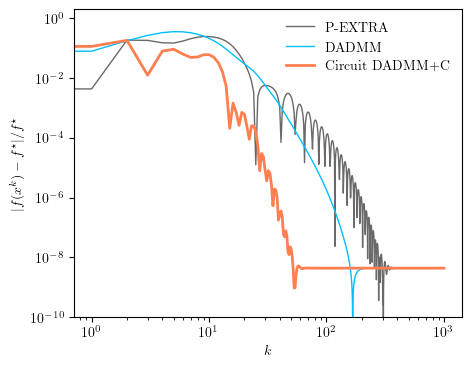

In [12]:
co.plot_methods([pg_f_reldiff,admm_f_reldiff,dadmm_c_f_reldiff],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-10, 2e-0, fname)

In [13]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-8)[0][0]

52

In [14]:
np.where(np.array(admm_f_reldiff) < 1e-8)[0][0]

154

In [15]:
np.where(np.array(pg_f_reldiff) < 1e-8)[0][0]

224